# Lecture 22

- What was the idea behind the random forest?
    - train a group of decision tree classifiers, each on a different random subset of the training set
    - obtain the predictions of all the individual trees
    - the class that gets the most votes is the kind of prediction

It is called a ensemble methods, and the random forest is one of them

The most popular ensemble methods is **Voting Classifiers**

### Voting Classifiers

- Suppose you have trained a few classifiers, each one achieving about 80% accuracy.     
- You may have a logistic regression classifier, an SVM classifier, a random forest classifier, a nearest neighbors classifier, and perhaps a few more 

In [2]:
from IPython.display import Image
Image(url="https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0701.png", width=1000)

- A very simple way to create an even better classifier is to aggregate the predictions of each classifier
    - the class that gets the most votes is the ensemble's prediction
    - This majority-vote classifier is called a **hard voting** classifier

In [3]:
from IPython.display import Image
Image(url="https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098125967/files/assets/mls3_0702.png", width=1000)

- Somewhat surprisingly, this voting classifier often achieves *a higher accuracy* than the best classifier in the ensemble
- In fact, even if each classifier is **a weak learner** (meaning it does only slightly better than random guessing), the ensemble can still be **a strong learner** (achieving high accuracy)
    - if there are a sufficient number of weak learners in the ensemble and they are sufficiently diverse.

- Ensemble methods work best when the predictors are as independent from one another as possible. 
- **One way** to get diverse classifiers is to train them using very different algorithms. 
    - This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.
    - Consider whether the random forest fits here

### Implementation

- Scikit-Learn provides a `VotingClassifier` class that’s quite easy to use
- Let’s try it on the moons dataset

In [4]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

- When you fit a `VotingClassifier`, it clones every estimator and fits the clones. 
- The original estimators are available via the `estimators` attribute, while the fitted clones are available via the `estimators_` attribute. 
- If you prefer a dict rather than a list, you can use `named_estimators` or `named_estimators_` instead.

In [5]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [6]:
voting_clf.predict(X_test[:1])

array([1])

In [7]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [8]:
voting_clf.score(X_test, y_test)

0.912

The voting classifier outperforms all the individual classifiers!

### Ok then, what is the random forest?

- One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. 
- **Another approach** is to use the same training algorithm for every predictor but train them on *different random subsets of the training set*
    - Remember **bagging** and **pasting**!
- Similar idea
    - Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.  

# Boosting

**Boosting** (originally called hypothesis boosting) refers to any ensemble method that can combine several weak learners into a strong learner

- The **gradient boosted regression tree** is the ensemble method that combines multiple decision trees to create a more powerful model
    - it can be used for regression and classification
- In contrast to the random forest approach, gradient boosting works by building trees in a serial manner, where each tree tries to correct the mistakes of the previous one

- By default, there is no randomization in gradient boosted regression trees 
    - instead, strong pre-pruning is used
    - Gradient boosted trees often use very shallow trees, of depth one to five, which makes the model smaller in terms of memory and makes predictions faster. 
- The main idea behind gradient boosting is to combine many simple models (in this context known as weak learners), like shallow trees. 
    - Each tree can only provide good predictions on part of the data, and so more and more trees are added to iteratively improve performance.

- Gradient boosted trees are frequently the winning entries in machine learning competitions, and are widely used in industry. 
- They are generally a bit more sensitive to parameter settings than random forests, but can provide better accuracy if the parameters are set correctly.

- Apart from the pre-pruning and the number of trees in the ensemble, another important parameter of gradient boosting is the `learning_rate` 
    - which controls how strongly each tree tries to correct the mistakes of the previous trees. 
    - A higher learning rate means each tree can make stronger corrections, allowing for more complex models. 
- Adding more trees to the ensemble, which can be accomplished by increasing `n_estimators`, also increases the model complexity, as the model has more chances to correct mistakes on the training set.

See: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
- Default params
    - `learning_rate` = 0.1
    - `max_depth` = 3


In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.958


- As the training set accuracy is 100%, we are likely to be overfitting. 
- To reduce overfitting, we could either apply stronger pre-pruning by limiting the maximum depth or lower the learning rate:

In [11]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.972


In [12]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.958


Both methods of decreasing the model complexity reduced the training set accuracy, as expected. 

In this case, lowering the maximum depth of the trees provided a significant improvement of the model, while lowering the learning rate only increased the generalization performance slightly.

- We can again visualize the feature importances to get more insight into our model
    - As we used 100 trees, it is impractical to inspect them all, even if they are all of depth 1

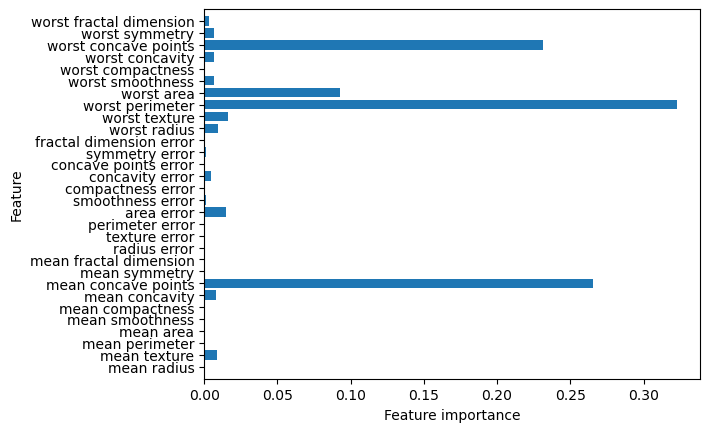

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)

We can see that the feature importances of the gradient boosted trees are somewhat similar to the feature importances of the random forests, though the gradient boosting completely ignored some of the features.

- As both gradient boosting and random forests perform well on similar kinds of data, a common approach is to first try random forests, which work quite robustly. 
    - If random forests work well but prediction time is at a premium, or it is important to squeeze out the last percentage of accuracy from the machine learning model, moving to gradient boosting often helps.

If you want to apply gradient boosting to a large-scale problem, it might be worth looking into the `xgboost` package and its Python interface, which at the time of writing is faster (and sometimes easier to tune) than the `scikit-learn` implementation of gradient boosting on many datasets.

### Little theory 

- Gradient boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor.
    - this method tries to fit the new predictor to the *residual errors* made by the previous predictor

Let’s go through a simple regression example, using decision trees as the base predictors

In [16]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)


DecisionTreeRegressor(max_depth=2, random_state=42)

Next, we’ll train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [17]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

And then we’ll train a third regressor on the residual errors made by the second predictor:

In [18]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

Now we have an ensemble containing three trees. 

It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [20]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

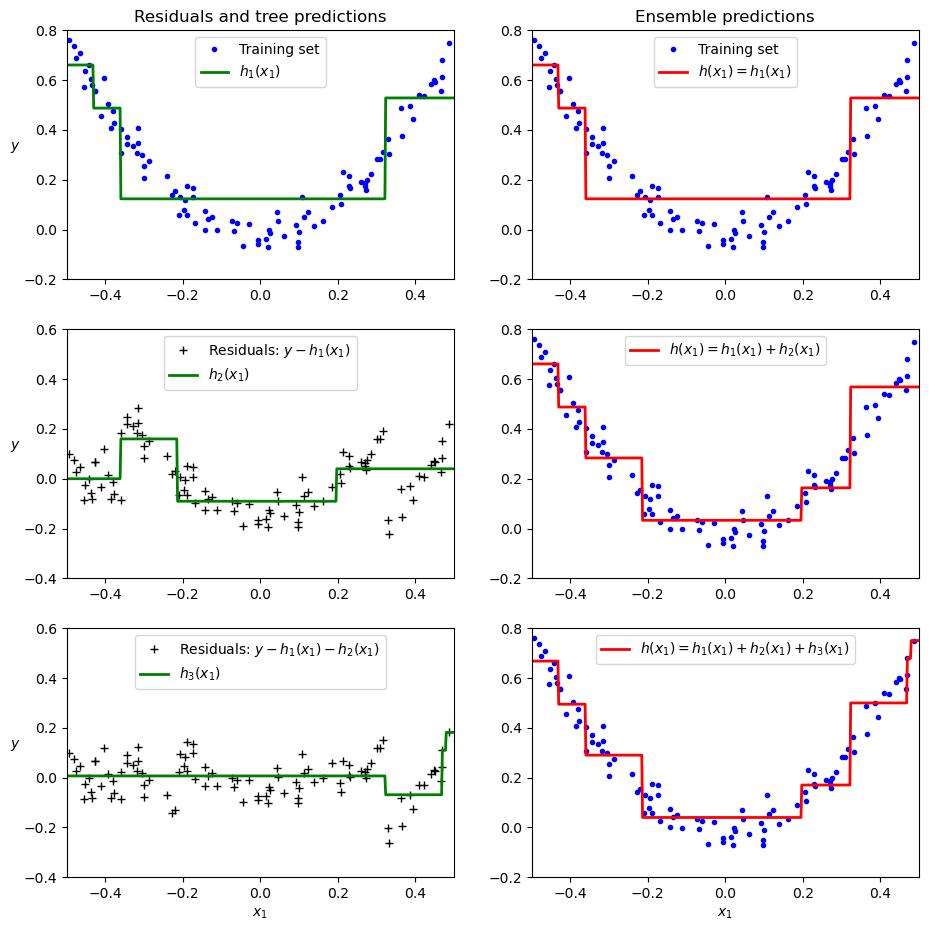

In [21]:
# extra code – this cell generates and saves Figure 7–9

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")
plt.show()

- Figure represents the predictions of these three trees in the left column, and the ensemble's predictions in the right column. 
- In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. 
- In the second row, a new tree is trained on the residual errors of the first tree. 
    - On the right you can see that the ensemble's predictions are equal to the sum of the predictions of the first two trees. 
- Similarly, in the third row another tree is trained on the residual errors of the second tree. 
    - You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

You can use Scikit-Learn’s `GradientBoostingRegressor` class to train the ensembles more easily (there's also a `GradientBoostingClassifier` class for classification).

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

- The `learning_rate` hyperparameter scales the contribution of each tree. 
- If you set it to a low value, such as `0.05`, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. 
    - This is a regularization technique called **shrinkage**

In [24]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

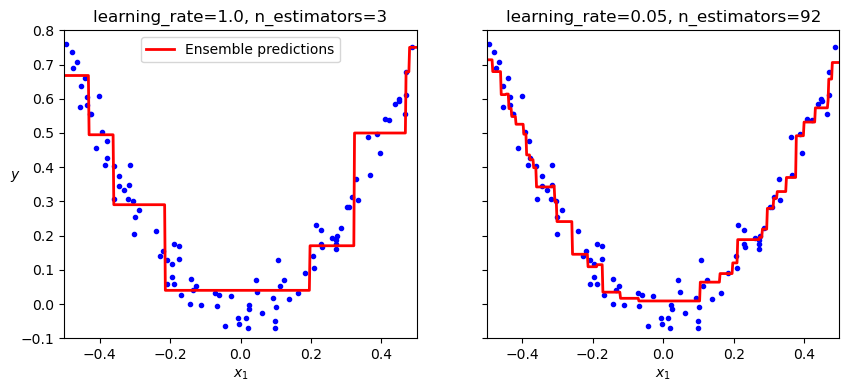

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")
plt.show()

 Figure shows two GBRT ensembles trained with different hyperparameters: the one on the left does not have enough trees to fit the training set, while the one on the right has about the right amount. 
 
 If we added more trees, the GBRT would start to overfit the training set.

## Little more advanced

- To find the optimal number of trees, you could perform cross-validation using `GridSearchCV` or `RandomizedSearchCV`, as usual, but there’s a simpler way 
    - if you set the `n_iter_no_change` hyperparameter to an integer value, say 10, then the `GradientBoostingRegressor` will automatically stop adding more trees during training if it sees that the last 10 trees didn’t help. 
    - This is called **early stopping**, but with a little bit of patience: it tolerates having no progress for a few iterations before it stops. 

In [26]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

If you set `n_iter_no_change` too low, training may stop too early and the model will underfit. 

But if you set it too high, it will overfit instead. 

We also set a fairly small learning rate and a high number of estimators, but the actual number of estimators in the trained ensemble is much lower, thanks to early stopping:

In [28]:
gbrt_best.n_estimators_

92

- When `n_iter_no_change` is set, the `fit()` method automatically splits the training set into a smaller training set and a validation set 
    - this allows it to evaluate the model's performance each time it adds a new tree. 
    - The size of the validation set is controlled by the `validation_fraction` hyperparameter, which is 10% by default. 
    - The `tol` hyperparameter determines the maximum performance improvement that still counts as negligible. 
        - It defaults to 0.0001.